In [248]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score,StratifiedKFold,train_test_split,GridSearchCV
from sklearn.feature_selection import SelectKBest,f_classif,chi2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from grid_search_useful_tools import plot_grid_search,table_grid_search
from attribute_sample import attribute_impact
import numpy as np

from warnings import filterwarnings

filterwarnings('ignore')

In [249]:
from sklearn import metrics
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.model_selection import cross_val_score
import numpy as np

import time

def attribute_impact(models,X,y,n_attributes_in_range):

        """
        Parameter:
        X: Données d'entrainnement contenant des variables independantes
        y: les labels des variables indépendantes pour les données d'entrainnement
        n_attributes_in_range: Le range du nombre de variable à extraire de l'ensemble des variables indépendantes
        threshold: La proportion de l'information à selectionner afin de supprimer des données abérantes

        Return:
        
        """
    
        scores_means={}
        scores_stds={}
        times={}
        
        
        for name,model in zip(models.keys(),models.values()):
            
            #train_scores,test_scores=initiate_dict(models)

            #train_scores[name]=[]
            
            check_mean={"accuracy_mean":[],"precision_mean":[],"recall_mean":[],"f1_score_mean":[]}
            check_std={"accuracy_std":[],"precision_std":[],"recall_std":[],"f1_score_std":[]}
            time_dict={}

            for num_attributes in n_attributes_in_range:

                #Intialisation de la méthode de selection

                selector=SelectKBest(score_func=f_classif, k=num_attributes)

                # Entrainnement de la méthode
                selector_fitted=selector.fit(X,y)

                # Récuperation des variables sélectionnées
                columns=X.columns[selector.get_support()]

                #test_scores[name]=check
                
                start_time=time.time()

                score_accuracy=cross_val_score(model,X[columns],y,cv=5,scoring='accuracy',n_jobs=-1)
                score_precision=cross_val_score(model,X[columns],y,cv=5,scoring='precision',n_jobs=-1)
                score_recall=cross_val_score(model,X[columns],y,cv=5,scoring='recall',n_jobs=-1)
                score_f1=cross_val_score(model,X[columns],y,cv=5,scoring='f1',n_jobs=-1)
                
                end_time=time.time()

                time_dict[num_attributes]=end_time-start_time

                #Testing score
                #Accuracy
                check_mean["accuracy_mean"].append(np.mean(score_accuracy))
                check_std["accuracy_std"].append(np.std(score_accuracy))

                #Presicion
                check_mean["precision_mean"].append(np.mean(score_precision))
                check_std["precision_std"].append(np.std(score_precision))


                #Recall
                check_mean["recall_mean"].append(np.mean(score_recall))
                check_std["recall_std"].append(np.std(score_recall))

                #F1-Score
                check_mean["f1_score_mean"].append(np.mean(score_f1))
                check_std["f1_score_std"].append(np.std(score_f1))

            scores_means[name]=check_mean
            scores_stds[name]=check_std
            times[name]=time_dict
                
        return scores_means,scores_stds,times

### Data loading and splitting

In [250]:
train_data=pd.read_csv("train_ready_modelisation.csv")
test_data=pd.read_csv("test_ready_modelisation.csv")

In [251]:
X=train_data.drop(columns=["Survived"])
y=train_data["Survived"]

X.shape,y.shape

((891, 19), (891,))

In [252]:
X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=.1)

### Naive Bayes

##### Before optimisation

In [253]:
from sklearn.metrics import classification_report


GNB=GaussianNB()
GNB.fit(X_train,y_train)

y_predict=GNB.predict(X_valid)

print(classification_report(y_valid,y_predict))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76        49
           1       0.71      0.73      0.72        41

    accuracy                           0.74        90
   macro avg       0.74      0.74      0.74        90
weighted avg       0.75      0.74      0.74        90



#### After optimisation

In [254]:
parameters = {
    'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}

grid_gnb=GridSearchCV(GNB, parameters, cv=10, verbose=0, n_jobs=-1)

grid_gnb.fit(X_train, y_train)

plot_grid_search(grid_gnb)
table_grid_search(grid_gnb)

mean_test_score,mean_fit_time,mean_score_time,param_var_smoothing
0.782778,0.004669,0.003659,0.000010


In [255]:
from sklearn.metrics import classification_report


y_predict=grid_gnb.predict(X_valid)

print(classification_report(y_valid,y_predict))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78        49
           1       0.75      0.66      0.70        41

    accuracy                           0.74        90
   macro avg       0.75      0.74      0.74        90
weighted avg       0.74      0.74      0.74        90



#### Attribute selection

In [257]:
n_attributes_in_range=range(1,len(X.columns)+1)
scores_means_attr,scores_std_attr,times=attribute_impact({"bayes":grid_gnb},X,y,n_attributes_in_range=n_attributes_in_range)

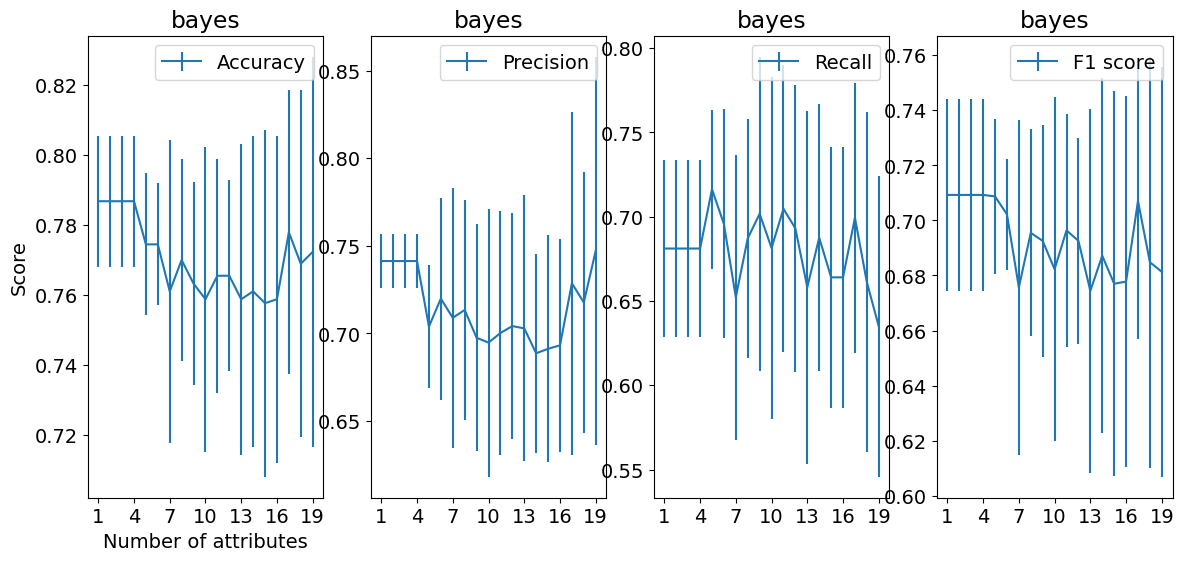

In [258]:
plt.rcParams.update({'font.size':14})
fig,axes=plt.subplots(nrows=1,ncols=4,figsize=(14,6))

axes[0].errorbar(n_attributes_in_range,scores_means_attr["bayes"]["accuracy_mean"],scores_std_attr["bayes"]["accuracy_std"],label="Accuracy")
axes[1].errorbar(n_attributes_in_range,scores_means_attr["bayes"]["precision_mean"],scores_std_attr["bayes"]["precision_std"],label="Precision")
axes[2].errorbar(n_attributes_in_range,scores_means_attr["bayes"]["recall_mean"],scores_std_attr["bayes"]["recall_std"],label="Recall")
axes[3].errorbar(n_attributes_in_range,scores_means_attr["bayes"]["f1_score_mean"],scores_std_attr["bayes"]["f1_score_std"],label="F1 score")
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
axes[0].set_xlabel("Number of attributes")
axes[0].set_ylabel("Score")
axes[0].set_title("bayes")
axes[1].set_title("bayes")
axes[2].set_title("bayes")
axes[3].set_title("bayes")
axes[0].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[1].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[2].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[3].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
plt.show()

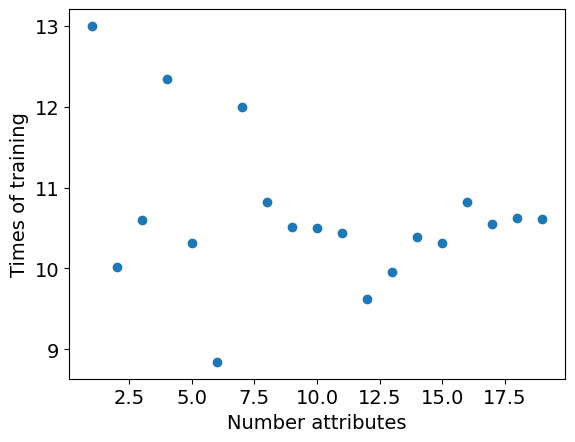

In [259]:
plt.plot(times['bayes'].keys(),times['bayes'].values(),"o")
plt.xlabel("Number attributes")
plt.ylabel("Times of training")
plt.show()

### After attribute selection

In [263]:
selector=SelectKBest(score_func=chi2,k=4)

# Entrainnement de la méthode
selector_fitted=selector.fit(X,y)

# Récuperation des variables sélectionnées
columns=X.columns[selector.get_support()]

grid_gnb=GridSearchCV(GNB, parameters, cv=5, verbose=1, n_jobs=-1)

grid_gnb.fit(X_train[columns], y_train)

plot_grid_search(grid_gnb)
table_grid_search(grid_gnb)

y_predict=grid_gnb.predict(X_valid[columns])

print(classification_report(y_valid,y_predict))

Fitting 5 folds for each of 14 candidates, totalling 70 fits


mean_test_score,mean_fit_time,mean_score_time,param_var_smoothing
0.787717,0.003610,0.009374,0.000000
0.787717,0.004949,0.003499,0.000000
0.787717,0.006029,0.007224,0.000000
0.787717,0.008152,0.004347,0.000000
0.787717,0.008363,0.010466,0.000001
0.787717,0.008613,0.007726,0.000000
0.787717,0.008615,0.011236,0.000000
0.787717,0.010316,0.013625,0.000000
0.787717,0.011224,0.003009,0.000000
0.787717,0.018744,0.006607,0.000000


              precision    recall  f1-score   support

           0       0.73      0.82      0.77        49
           1       0.74      0.63      0.68        41

    accuracy                           0.73        90
   macro avg       0.74      0.73      0.73        90
weighted avg       0.73      0.73      0.73        90



### Submission

In [264]:
from datetime import datetime

version=(datetime.now()).strftime("%D|%H:%M:%S").replace('/','-')

submission_gnb=pd.read_csv("gender_submission.csv")

submission_gnb["Survived"]=grid_gnb.predict(test_data[columns])

submission_gnb.to_csv("submission_gnb_"+str(version)+".csv",index=False)

### Decision Tree

#### Preprunning

In [265]:
DT=DecisionTreeClassifier()

DT.fit(X_train,y_train)

y_predict=DT.predict(X_valid)

print(classification_report(y_predict,y_valid))


              precision    recall  f1-score   support

           0       0.82      0.82      0.82        49
           1       0.78      0.78      0.78        41

    accuracy                           0.80        90
   macro avg       0.80      0.80      0.80        90
weighted avg       0.80      0.80      0.80        90



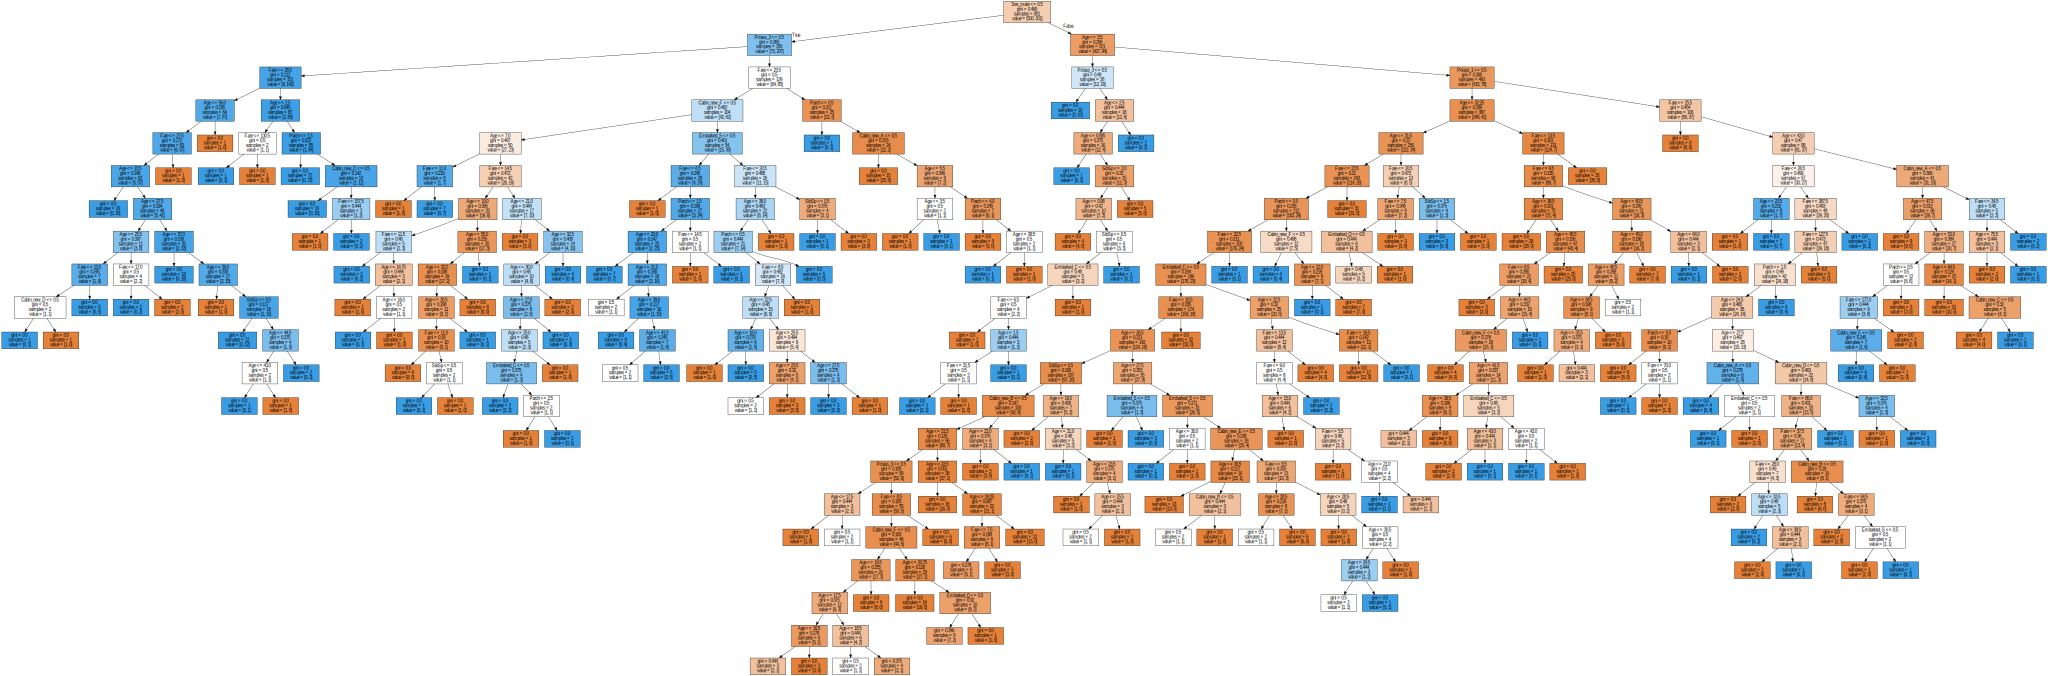

In [274]:
import graphviz


dot_data = export_graphviz(DT, out_file=None, 
                                feature_names=X_train.columns,  
                                filled=True)

graphviz.Source(dot_data,format='png')

#### Postprunning

In [272]:
criter_range=['gini','entropy']
max_depth=range(15)
min_samples_split=range(5,10)
min_samples_leaf=range(1,6)

param_grid={'criterion':criter_range,'max_depth':max_depth,
            'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf
            }


grid_DT=GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1
) 

grid_DT.fit(X_train,y_train)

plot_grid_search(grid_DT)
table_grid_search(grid_DT)

mean_test_score,mean_fit_time,mean_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split
0.828952,0.004907,0.002790,entropy,6,5,8


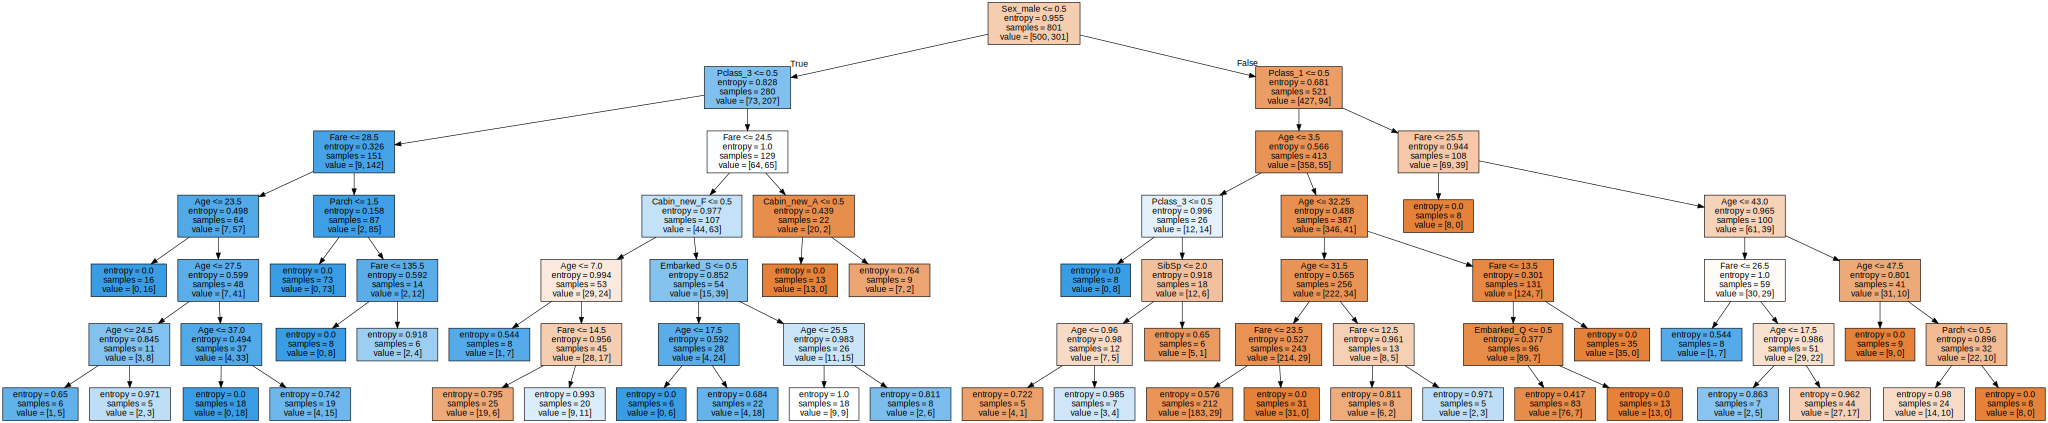

In [273]:
import graphviz


dot_data = export_graphviz(grid_DT.best_estimator_, out_file=None, 
                                feature_names=X_train.columns,  
                                filled=True)

graphviz.Source(dot_data,format='png')

#### Attribute selection

In [ ]:
n_attributes_in_range=range(1,len(X.columns)+1)
scores_means_attr,scores_std_attr,times=attribute_impact({"DT":grid_DT.best_estimator_},X,y,n_attributes_in_range=n_attributes_in_range)

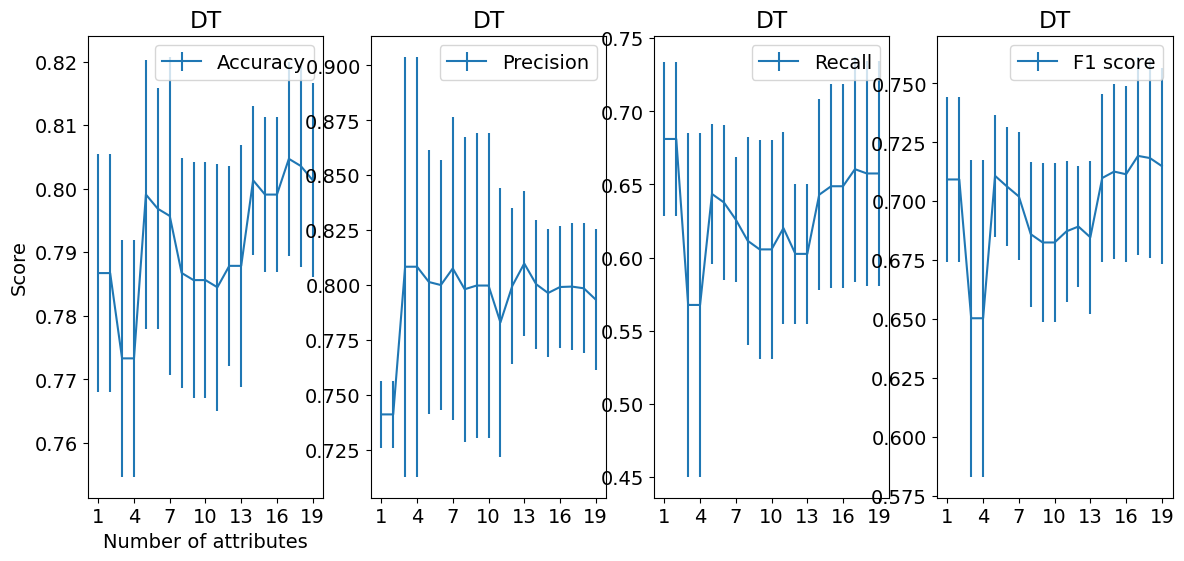

In [ ]:
plt.rcParams.update({'font.size':14})
fig,axes=plt.subplots(nrows=1,ncols=4,figsize=(14,6))

axes[0].errorbar(n_attributes_in_range,scores_means_attr["DT"]["accuracy_mean"],scores_std_attr["DT"]["accuracy_std"],label="Accuracy")
axes[1].errorbar(n_attributes_in_range,scores_means_attr["DT"]["precision_mean"],scores_std_attr["DT"]["precision_std"],label="Precision")
axes[2].errorbar(n_attributes_in_range,scores_means_attr["DT"]["recall_mean"],scores_std_attr["DT"]["recall_std"],label="Recall")
axes[3].errorbar(n_attributes_in_range,scores_means_attr["DT"]["f1_score_mean"],scores_std_attr["DT"]["f1_score_std"],label="F1 score")
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
axes[0].set_xlabel("Number of attributes")
axes[0].set_ylabel("Score")
axes[0].set_title("DT")
axes[1].set_title("DT")
axes[2].set_title("DT")
axes[3].set_title("DT")
axes[0].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[1].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[2].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
axes[3].set_xticks(np.arange(min(n_attributes_in_range), max(n_attributes_in_range)+1, 3.0))
plt.show()

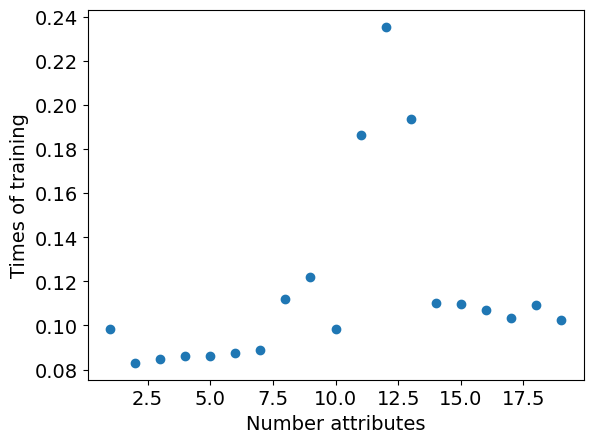

In [ ]:
plt.plot(times['DT'].keys(),times['DT'].values(),"o")
plt.xlabel("Number attributes")
plt.ylabel("Times of training")
plt.show()

### After sttribute selection

In [ ]:
selector=SelectKBest(score_func=chi2,k=5)

# Entrainnement de la méthode
selector_fitted=selector.fit(X,y)

# Récuperation des variables sélectionnées
columns=X.columns[selector.get_support()]

grid_DT=GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, verbose=0, n_jobs=-1)

grid_DT.fit(X_train[columns],y_train)

plot_grid_search(grid_DT)
table_grid_search(grid_DT)

y_predict=grid_DT.predict(X_valid[columns])

print(classification_report(y_valid,y_predict))

mean_test_score,mean_fit_time,mean_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split
0.815950,0.005025,0.002444,gini,9,1,5


              precision    recall  f1-score   support

           0       0.90      0.93      0.91        56
           1       0.88      0.82      0.85        34

    accuracy                           0.89        90
   macro avg       0.89      0.88      0.88        90
weighted avg       0.89      0.89      0.89        90



### Submission

In [ ]:
import uuid

from datetime import datetime

version=(datetime.now()).strftime("%D|%H:%M:%S").replace('/','-')

submission_DT=pd.read_csv("gender_submission.csv")

submission_DT["Survived"]=grid_DT.predict(test_data[columns])

submission_DT.to_csv("submission_DT_"+str(version)+".csv",index=False)

### Generer les graphics

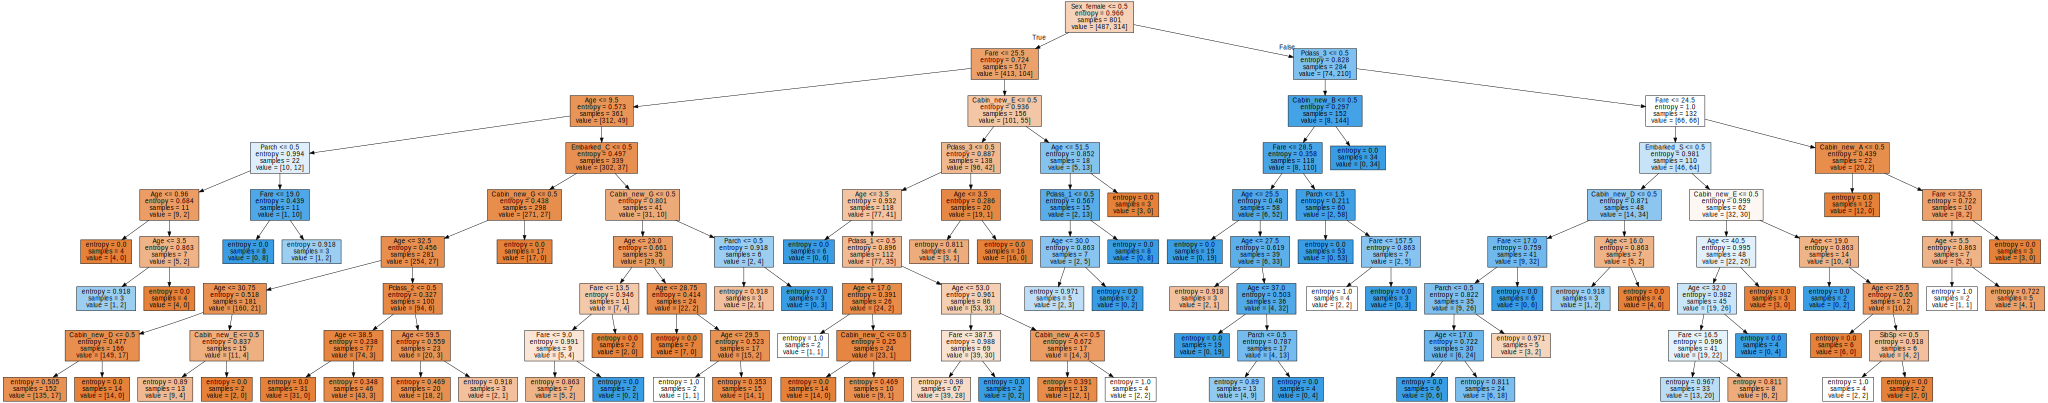

In [ ]:
import graphviz


dot_data = export_graphviz(grid_DT.best_estimator_, out_file=None, 
                                feature_names=X_train.columns,  
                                filled=True)

graphviz.Source(dot_data,format='png')